 # TellusLabs

TellusLabs' Crop Health Index(TL CHI) Historical Data


TL CHI historical data is availabe in CME DataMine and accessible through API, FSTP and AWS S3 transfer. This blog will introduce TL CHI data and its structure/format with simple data analysis. This blog is not suggesting any trading ideas or strategies.

Tellus data is downloadable from CME DataMine and the historical data is available from January 2003 to present (15 years). Data files are in CSV format and contain daily TL CHI or NDVI for each location and crop.
For the sample data analysis in this blog, 10 year of historical U.S. corn TL CHI was downloaded through API and saved in a local folder.

More information for data access:
http://www.cmegroup.com/market-data/datamine-api.html

# Data outlook and pattern

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-deep')
warnings.filterwarnings("ignore")


In [2]:
# import data, set index and convert it to datetime 
df_chi = pd.read_csv('./data/merged_chi_mutilated.csv', index_col='metric_date', parse_dates=True)
df_chi.head(3)

,crop,country_iso,geo_level,geo_id,geo_display_name,TELLUSCHIN
metric_date,,,,,,
2010-01-01,corn,USA,level_1,0,UNITED STATES,0.064150
2010-01-02,corn,USA,level_1,0,UNITED STATES,0.056903
2010-01-03,corn,USA,level_1,0,UNITED STATES,0.060015


Tellus historical data is separeted by date, crop, country and CHI/NDVI. For example, in a sample data file '20180401-TELLUSLABS_USA_soy_NDVI_0.csv', 35 US state level data is included. We are going to filter out state level data and use US country level data only in this analysis.

In [3]:
# US data only
df_us = df_chi.loc[df_chi['geo_display_name']=='UNITED STATES']

In [4]:
df_us.head(3)

,crop,country_iso,geo_level,geo_id,geo_display_name,TELLUSCHIN
metric_date,,,,,,
2010-01-01,corn,USA,level_1,0,UNITED STATES,0.064150
2010-01-02,corn,USA,level_1,0,UNITED STATES,0.056903
2010-01-03,corn,USA,level_1,0,UNITED STATES,0.060015


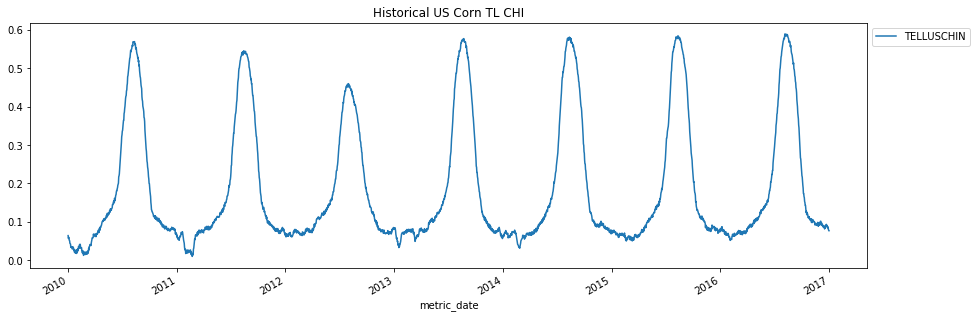

In [5]:
df_us['TELLUSCHIN'].plot(figsize=[15,5]);
plt.title('Historical US Corn TL CHI');
plt.legend(bbox_to_anchor=(1, 1), loc=2);

X - time
Y - TL CHI

10 year historical data shows clear seasonality with peaks in the summer

# Weekly average year-over-year comparison


In [6]:
df_pivot = pd.pivot_table(df_us, index=df_us.index.week, columns=df_us.index.year,
                    values='TELLUSCHIN', aggfunc='mean')

In [7]:
df_pivot.head(3)

metric_date,2010,2011,2012,2013,2014,2015,2016
metric_date,,,,,,,
1,0.046097,0.055986,0.067801,0.073931,0.068150,0.073786,0.081249
2,0.033196,0.063402,0.066840,0.052872,0.072560,0.076140,0.074686
3,0.026651,0.068007,0.065514,0.039416,0.066523,0.070359,0.068641


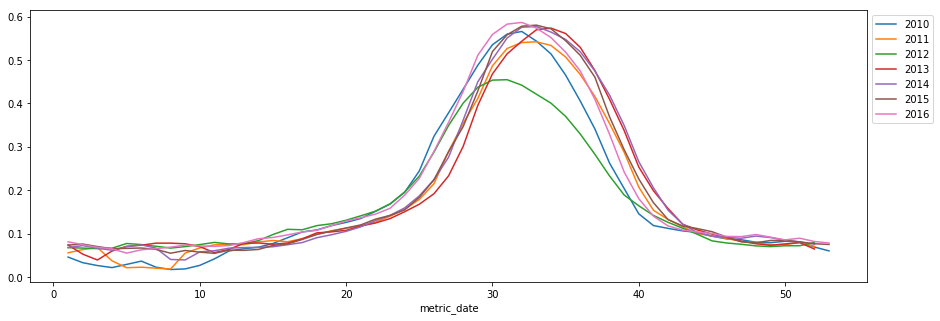

In [8]:
df_pivot.plot(figsize=[15,5]);
plt.legend(bbox_to_anchor=(1, 1), loc=2);

TL CHI year-over-year comparison

Y - TL CHI weekly average

X - Week of the year

2016 (purple) shows the highest TL CHI and 2012 (green) the lowest CHI. 

In [9]:
time_series = df_us['TELLUSCHIN']

# Breaking down data into seasonality and trend with statsmodels
Breaking down TL CHI historical data into seasonal, trend and residual components with statsmodels.

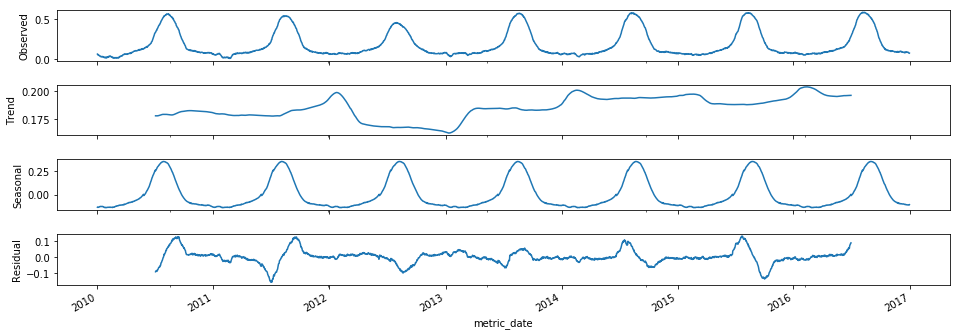

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(time_series, freq=365)
graph_decomp = decomp.plot()
graph_decomp.set_size_inches(15,5)

Graphs for raw data/trend/seasonal/residual components

From the decomposition, trend is going down significantly in 2012 and then recovered in 2013. Let's zoom-in the trend in 2011-2013

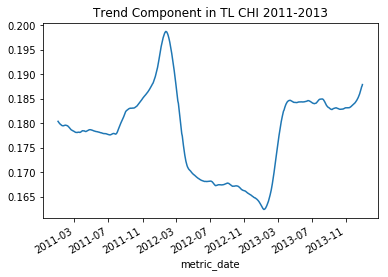

In [11]:
decomp.trend.loc['2011':'2013'].plot();
plt.title('Trend Component in TL CHI 2011-2013');

USDA published (January 2013) 'Crop Production 2012 Summary' and estimated 13% less production in corn production which correspond to TL CHI trend drop in 2012.

Estimation from USDA:
Corn for grain production is estimated at 10.8 billion bushels, up 1 percent from the November 1 forecast but 13 percent
below 2011. The average yield in the United States is estimated at 123.4 bushels per acre. This is up 1.1 bushels from the
November forecast but 23.8 bushels below the 2011 average yield of 147.2. Area harvested for grain is estimated at
87.4 million acres, down slightly from the November forecast, but up 4 percent from 2011.
http://usda.mannlib.cornell.edu/usda/nass/CropProdSu/2010s/2013/CropProdSu-01-11-2013.pdf


In [12]:
trend = decomp.trend.dropna()
trend = pd.DataFrame(trend)
#trend.head(3)

# Corn price & corn TL CHI
To find out the relationship between corn price and TL CHI, we will plot TL CHI and corn prices at the same time in various ways. Front month corn futures settlements prices are used as corn market prices. The data is also downloaded from CME Group and saved in a local drive.

In [13]:
df_sett = pd.read_csv('./data/corn_settlement.csv', index_col='date_sett', parse_dates=True)


# Price/TL CHI scatterplot

In [14]:
pchi = df_us.join(df_sett, how='outer')
pchi.head(2)

,crop,country_iso,geo_level,geo_id,geo_display_name,TELLUSCHIN,price_front
2003-12-30,NaN,NaN,NaN,NaN,NaN,NaN,242.5
2003-12-31,NaN,NaN,NaN,NaN,NaN,NaN,246.0


In [15]:
columns = pchi.columns[0:-2]
pchi.drop(columns, inplace=True, axis=1)
pchi['shifted-'] = pchi['price_front'].shift(-7)
pchi['shifted+'] = pchi['price_front'].shift(7)
pchi = pchi.dropna()

pchi.head(2)

,TELLUSCHIN,price_front,shifted-,shifted+
2010-01-04,0.056151,418.50,422.5,416.0
2010-01-05,0.051881,418.75,392.5,417.0


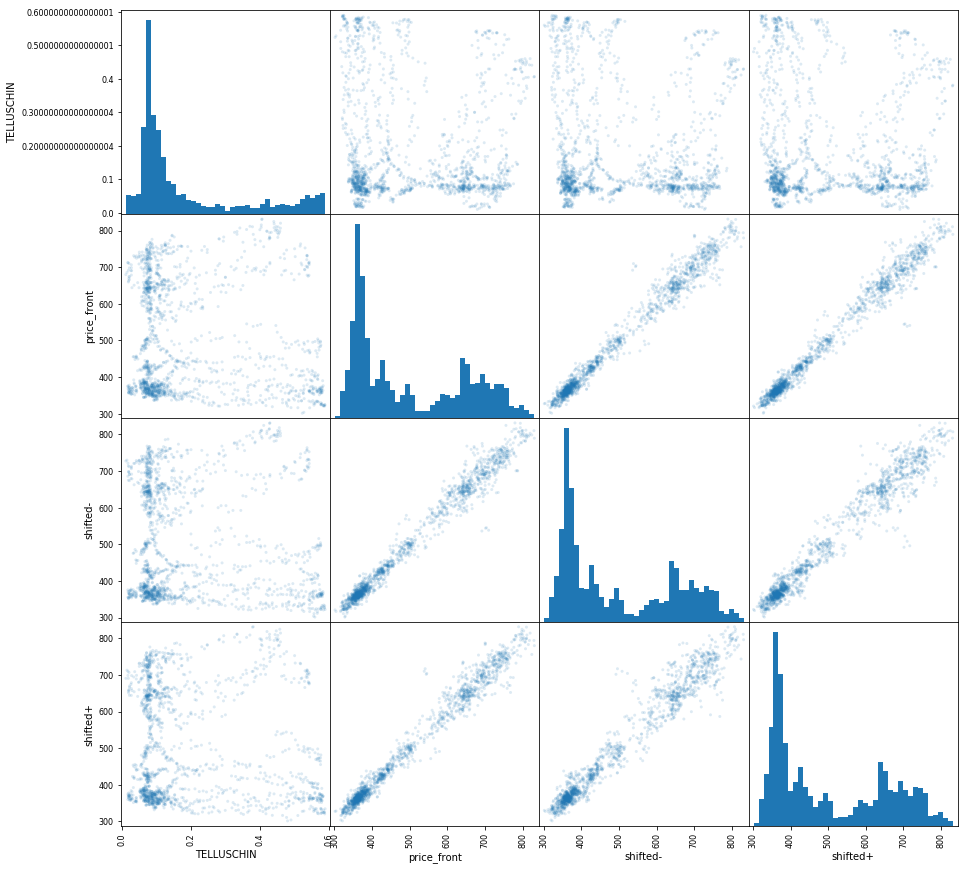

In [16]:
#pd.scatter_matrix(pchi,alpha=0.15, figsize=[15,15], diagonal='kde');
pd.scatter_matrix(pchi,alpha=0.15, hist_kwds={'bins':40},figsize=[15,15]);

From the scatter plot, TL CHI doesn't have strong relationship with futures price itself.

Three data scatter plot was plotted in the first row of the graph to see if there's any delayed or early reflection of TL CHI to the price

1. TL CHI vs front month futures price 
2. TL CHI vs front month futures price (early reflection, price shifted by +7 days)
3. TL CHI vs front month futures price (delayed reflection, price shifted by -7 days)


In [17]:
joined = trend.join(df_sett, how='outer')
joined.columns = ['trend','price_front']
joined = df_us.join(joined, how='outer')

joined = joined.dropna()


# Graph with TL CHI and futures prices

In [18]:
joined = joined.dropna()
#joined.head()

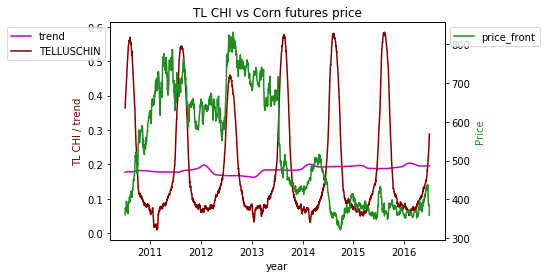

In [19]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(joined.index, joined['trend'], 'm-')
ax1.plot(joined.index, joined['TELLUSCHIN'], 'maroon')

ax2.plot(joined.index, joined['price_front'], 'forestgreen')

ax1.set_xlabel('year')
ax1.set_ylabel('TL CHI / trend', color='maroon')
ax2.set_ylabel('Price', color='forestgreen')

ax1.legend(bbox_to_anchor=(0, 1),loc=1)
ax2.legend(bbox_to_anchor=(1, 1),loc=2)
plt.title('TL CHI vs Corn futures price')
plt.show()
plt.rcParams['figure.figsize'] = 25,7


From 2010 to 2012, TL CHI were lower than others and corn prices were higher. Did lower TL CHI mean lower crop yield/short in supply and drive the price higher?
Graph with price, TL CHI and prior 3 year average TL CHI

In [20]:
df_yavg = df_pivot.rolling(window=3,axis=1).mean()
df_yavg.head(3)

metric_date,2010,2011,2012,2013,2014,2015,2016
metric_date,,,,,,,
1,NaN,NaN,0.056628,0.065906,0.069960,0.071955,0.074395
2,NaN,NaN,0.054479,0.061038,0.064091,0.067191,0.074462
3,NaN,NaN,0.053391,0.057646,0.057151,0.058766,0.068508


In [21]:
df_sett_avg = df_sett.resample('W').mean()
df_sett_avg.head(3)


,price_front
date_sett,
2004-01-04,247.25
2004-01-11,251.45
2004-01-18,268.80


In [22]:
df_pivot_sett = pd.pivot_table(df_sett, index=df_sett.index.week, columns=df_sett.index.year,
                    values='price_front', aggfunc='mean')

In [23]:
df_pivot_sett.head(3)

date_sett,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
date_sett,,,,,,,,,,,,,,,,
1,244.25,253.25,203.950,217.000,389.35,432.00,412.25,419.9,609.05,660.45,581.15,412.05,395.75,353.5500,358.6875,352.1250
2,NaN,251.45,202.250,213.000,370.25,478.45,414.55,390.3,627.25,633.30,695.20,423.10,400.35,357.5500,358.4500,348.0500
3,NaN,268.80,196.875,206.125,407.50,504.75,373.20,368.5,653.00,603.75,727.55,428.75,387.15,368.4375,366.6250,351.3125


In [24]:
df_sett_avg['price change'] = df_sett_avg['price_front'] - df_sett_avg['price_front'].shift(1)
df_sett_avg.head(3)

,price_front,price change
date_sett,,
2004-01-04,247.25,NaN
2004-01-11,251.45,4.20
2004-01-18,268.80,17.35


In [25]:
df_pivot_diff = pd.pivot_table(df_sett_avg, index=df_sett_avg.index.week, columns=df_sett_avg.index.year,
                    values='price change', aggfunc='mean')
df_pivot_diff.head(3)

date_sett,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
date_sett,,,,,,,,,,,,,,,
1,NaN,-1.500,2.375,-15.5625,11.9375,5.5625,4.5875,-12.45,10.9375,-6.125,-8.250,-9.0625,-6.7625,7.4375,-0.1875
2,4.20,-1.700,-4.000,-2.5625,15.7625,12.3000,-29.6000,18.20,-17.7000,5.575,0.725,-2.6500,4.0000,-0.2375,-4.0750
3,17.35,-5.375,-6.875,37.2500,26.3000,-41.3500,-21.8000,25.75,-29.5500,32.350,5.650,-13.2000,10.8875,8.1750,3.2625


In [27]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

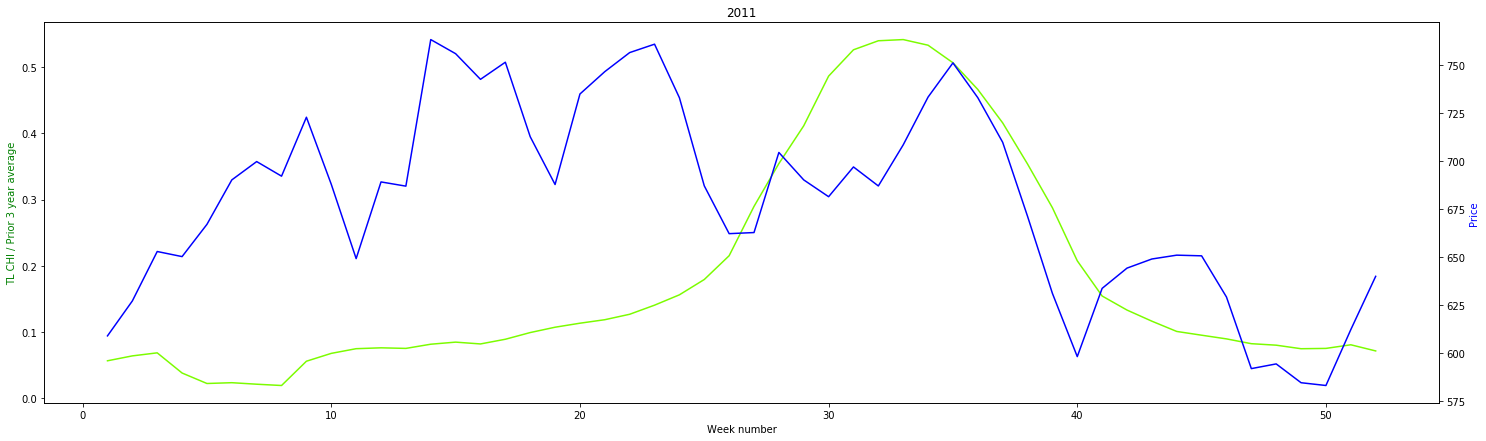

None


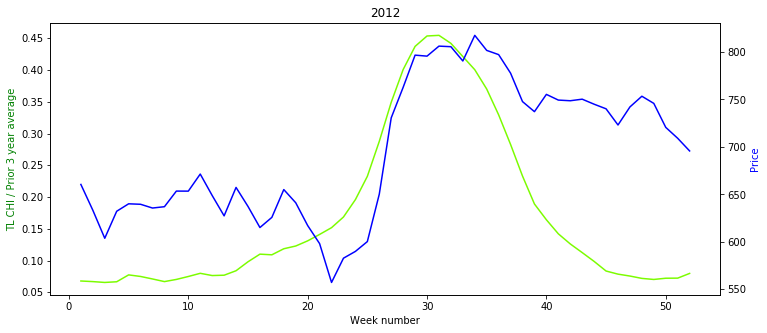

None


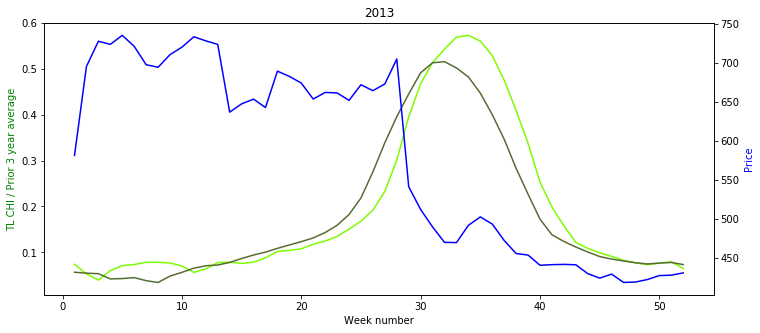

None


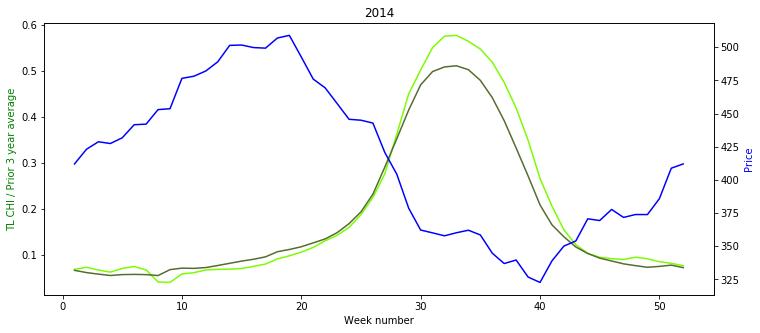

None


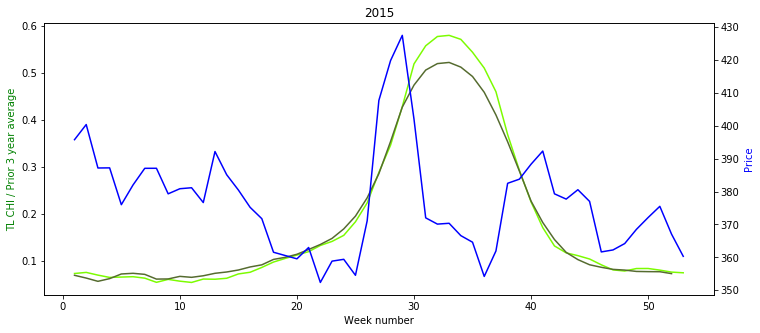

None


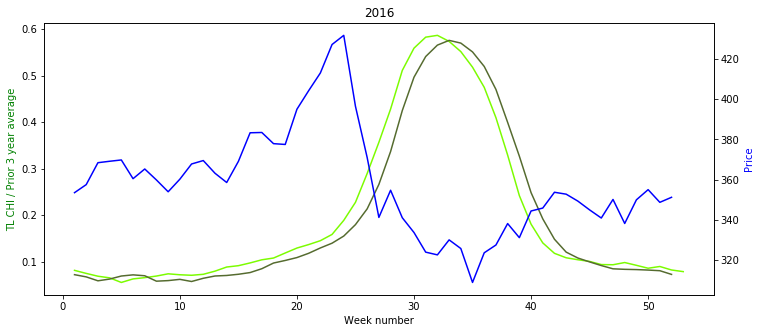

None


In [28]:
def comparison_gr (year):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    ax1.plot(df_pivot.index, df_pivot[[year]], 'lawngreen')
    ax1.plot(df_yavg.index, df_yavg[[year-1]], 'darkolivegreen')
    
    ax2.plot(df_pivot_sett.index, df_pivot_sett[[year]], 'b-')
    
    ax1.set_xlabel('Week number')
    ax1.set_ylabel('TL CHI / Prior 3 year average', color='g')
    ax2.set_ylabel('Price', color='b')
    
    plt.title(year)
    plt.show()
    plt.rcParams['figure.figsize'] = 12,5
    
for i in [2011,2012,2013,2014,2015,2016]:
    print (comparison_gr(i))

Light green: average of the week

Dark green: average of the week in prior 3 years

Blue: front month corn futures settlement

This was plotted to show if relatively high or low TL CHI(compare to the average of prior years) affects to corn prices
